In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import os
import cv2
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [ ]:
from google.colab import drive
drive.flush_and_unmount()  # 드라이브 강제 해제

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 흑점 갯수 데이터 로드 (예: CSV 파일에서)
labels_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/이기언_강사님_자료/프로젝트/시계열/daily_sunspots_time_series_1850-01_2024-05.csv')

# 날짜를 datetime 형식으로 변환
labels_df['date'] = pd.to_datetime(labels_df['date'], format='%Y-%m-%d')

# 원하는 기간 설정
start_date = pd.to_datetime('2024-04-01')
end_date = pd.to_datetime('2024-04-30')

# 필터링
filtered_labels_df = labels_df[(labels_df['date'] >= start_date) & (labels_df['date'] <= end_date)]

# 필터링된 결과 확인
print(filtered_labels_df)

            date  year  month  day  date_frac  counts   std  nobs indicator
63643 2024-04-01  2024      4    1   2024.250      32  11.6    32         *
63644 2024-04-02  2024      4    2   2024.253      39  18.6    22         *
63645 2024-04-03  2024      4    3   2024.255      38  15.6    31         *
63646 2024-04-04  2024      4    4   2024.258      48  11.2    34         *
63647 2024-04-05  2024      4    5   2024.261      78  13.6    31         *
63648 2024-04-06  2024      4    6   2024.264      80  10.6    33         *
63649 2024-04-07  2024      4    7   2024.266      84  14.7    33         *
63650 2024-04-08  2024      4    8   2024.269      77  16.1    23         *
63651 2024-04-09  2024      4    9   2024.272      55  13.9    33         *
63652 2024-04-10  2024      4   10   2024.275      55  10.8    32         *
63653 2024-04-11  2024      4   11   2024.277      90   8.7    30         *
63654 2024-04-12  2024      4   12   2024.280      86  12.6    41         *
63655 2024-0

In [ ]:
filtered_labels_df.head()

,date,year,month,day,date_frac,counts,std,nobs,indicator
63643,2024-04-01,2024,4,1,2024.250,32,11.6,32,*
63644,2024-04-02,2024,4,2,2024.253,39,18.6,22,*
63645,2024-04-03,2024,4,3,2024.255,38,15.6,31,*
63646,2024-04-04,2024,4,4,2024.258,48,11.2,34,*
63647,2024-04-05,2024,4,5,2024.261,78,13.6,31,*


In [ ]:
# 1. 이미지 데이터 불러오기
def load_images_from_directory(root_folder_path):
    images = {}
    for year_folder in os.listdir(root_folder_path):
        year_path = os.path.join(root_folder_path, year_folder)
        if os.path.isdir(year_path):
            for filename in os.listdir(year_path):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):  # 다양한 이미지 확장자 지원
                    date_str = filename.split('_')[0]
                    date = datetime.strptime(date_str, '%Y%m%d')

                    img_path = os.path.join(year_path, filename)
                    img = cv2.imread(img_path)

                    if img is not None:  # 이미지가 성공적으로 로드되었는지 확인
                        images[date] = img  # 날짜를 키로 사용
                    else:
                        print(f"Warning: Image at {img_path} could not be loaded.")
    return images

# 1. 이미지 데이터 불러오기
def load_images(folder_path):
    images = {}

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):  # 다양한 이미지 확장자 지원
            date_str = filename.split('_')[0]
            date = datetime.strptime(date_str, '%Y%m%d')

            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)

            if img is not None:  # 이미지가 성공적으로 로드되었는지 확인
                images[date] = img  # 날짜를 키로 사용
            else:
                print(f"Warning: Image at {img_path} could not be loaded.")
    return images

root_folder_path = '/content/drive/MyDrive/Colab Notebooks/이기언_강사님_자료/프로젝트/시계열/sun_spot_images'
folder_path = '/content/drive/MyDrive/Colab Notebooks/이기언_강사님_자료/프로젝트/시계열/sun_spot_images/202404'
# images = load_images_from_directory(root_folder_path)
images = load_images(folder_path)

# 2. 이미지 데이터 이름 날짜로 변경 - 이미 위에서 했으므로 생략

# 3. 이미지 전처리 - 흑백, 스케일, 리사이즈 256
def preprocess_images(images):
    processed_images = {}
    for date, img in images.items():
        # 흑백 처리
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 컬러 이미지를 흑백으로 변환
        # 리사이즈
        img_resized = cv2.resize(img_gray, (256, 256))  # 256x256 크기로 조정
        # 정규화 (0~1 스케일)
        img_normalized = img_resized / 255.0  # 0~255 값을 0~1로 정규화
        processed_images[date] = img_normalized
    return processed_images

images = preprocess_images(images)

# 4. 이미지 데이터 결측치 처리 - 선형 보간
def linear_interpolate_images(images):
    dates = sorted(images.keys())
    for i in range(1, len(dates)):
        prev_date = dates[i - 1]
        next_date = dates[i]
        days_between = (next_date - prev_date).days

        if days_between > 1:
            for j in range(1, days_between):
                missing_date = prev_date + timedelta(days=j)
                alpha = j / days_between

                # 선형 보간
                interpolated_image = (1 - alpha) * images[prev_date] + alpha * images[next_date]
                images[missing_date] = interpolated_image

    return images

images = linear_interpolate_images(images)

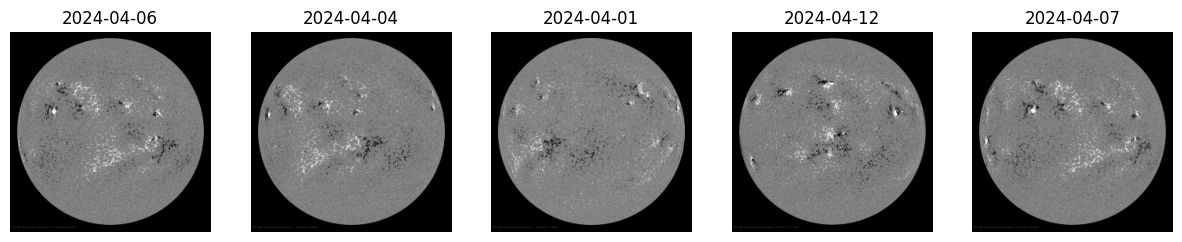

In [ ]:
# 이미지 확인하기
def display_images(images, n=5):
    plt.figure(figsize=(15, 5))

    # n개의 이미지를 표시
    for i, (date, img) in enumerate(images.items()):
        if i >= n:
            break
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')  # 흑백 이미지로 표시
        plt.title(date.strftime('%Y-%m-%d'))  # 날짜 제목
        plt.axis('off')  # 축 제거
    plt.show()

# 전처리된 이미지 확인 (예: 처음 5개 이미지)
display_images(images, n=5)

In [ ]:
# 5. 이미지 라벨링
labels = {row['date']: row['counts'] for _, row in filtered_labels_df.iterrows()}

# 이미지와 라벨 결합
def create_dataset(images, labels):
    X, y = [], []
    for date, img in images.items():
        if date in labels:
            X.append(img)
            y.append(labels[date])
    return np.array(X), np.array(y)

X_images, y_labels = create_dataset(images, labels)

# 이미지 데이터 형태 변경 (CNN 입력 형태로)
X_images = X_images.reshape(-1, 256, 256, 1)

In [ ]:
y_labels[0]

13

In [ ]:
def display_train_images(images, n=5):
    plt.figure(figsize=(15, 5))

    # n개의 이미지를 표시
    for i in range(min(n, len(images))):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap='gray')  # 흑백 이미지로 표시
        plt.axis('off')  # 축 제거
    plt.show()

# X_images 확인하기 (예: 처음 5개 이미지)
display_train_images(X_images, n=5)

In [ ]:
# n개의 이미지를 표시
for i, (date, img) in enumerate(images.items()):
    print(date.strftime('%Y-%m-%d'))

2024-04-06
2024-04-04
2024-04-01
2024-04-12
2024-04-07
2024-04-08
2024-04-05
2024-04-02
2024-04-11
2024-04-03
2024-04-09
2024-04-10
2024-04-25
2024-04-22
2024-04-30
2024-04-14
2024-04-18
2024-04-26
2024-04-15
2024-04-19
2024-04-27
2024-04-28
2024-04-29
2024-04-24
2024-04-17
2024-04-21
2024-04-16
2024-04-23
2024-04-13
2024-04-20


In [ ]:
print(f'저장된 이미지 수: {len(images.items())}')

저장된 이미지 수: 30


In [ ]:
# 저장할 폴더 경로
# output_folder = '/content/drive/MyDrive/Colab Notebooks/이기언_강사님_자료/프로젝트/시계열/sun_spot_images/train_images'  # 로컬 경로로 변경
output_folder = '/content/drive/MyDrive/Colab Notebooks/이기언_강사님_자료/프로젝트/시계열/sun_spot_images/test_images'  # 로컬 경로로 변경

# 폴더가 존재하지 않으면 생성
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 이미지 저장
for i, (date, image) in enumerate(images.items()):
    filename = os.path.join(output_folder, f'{date.strftime("%Y-%m-%d")}.jpg')
    image_to_save = (image * 255).astype('uint8')
    cv2.imwrite(filename, image_to_save)

print(f'저장된 이미지 수: {len(images.items())}')



저장된 이미지 수: 30
